# Binary classification using logistic regression

One of the classic public datasets used to demonstrate binary classification is the [Titanic dataset](https://www.kaggle.com/c/titanic), which lists 891 of the the passengers aboard the RMS Titanic when it sank on April 15, 1912. The dataset includes the name of each passenger as well as other information such as the fare class, the fare price, the person's age and gender, and whether that person survived the sinking of the ship. In this example, we will build a binary-classification model that predicts whether a passenger will survive. We will use logistic regression as the learning algorithm.

![](Images/titanic.png)

## Load and prepare the dataset

The first step is to load the dataset and prepare it for training a machine-learning model. One of the reasons the Titanic dataset is popular is that it provides ample opportunity for data scientists to practice their data-cleaning skills.

In [1]:
import pandas as pd

df = pd.read_csv('Data/titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Determine whether any of the columns in the dataset are missing values.

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Filter the dataset to remove columns that won't be used, one-hot-encode the "Sex" and "Pclass" columns, and remove rows with missing values.

In [3]:
df = df[['Survived', 'Age', 'Sex', 'Pclass']]
df = pd.get_dummies(df, columns=['Sex', 'Pclass'])
df.dropna(inplace=True)
df.head()

,Survived,Age,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3
0,0,22.0,0,1,0,0,1
1,1,38.0,1,0,1,0,0
2,1,26.0,1,0,0,0,1
3,1,35.0,1,0,1,0,0
4,0,35.0,0,1,0,0,1


The next step is to split the data into two datasets: one for training and one for testing. We'll use a stratified split to create a balanced distribution of samples in the training dataset and the testing dataset.

In [4]:
from sklearn.model_selection import train_test_split

x = df.drop('Survived', axis=1)
y = df['Survived']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=0)

## Build and train a model

Our classifier will use logistic regression. Logistic regression not only makes predictions, it yields probabilities as well.

In [5]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=0)
model.fit(x_train, y_train)

LogisticRegression(random_state=0)

Get an accuracy score.

In [6]:
model.score(x_test, y_test)

0.8321678321678322

Cross-validate the model using five folds.

In [7]:
from sklearn.model_selection import cross_val_score

cross_val_score(model, x, y, cv=5).mean()

0.7857480547621394

Use a confusion matrix to see how the model performed during testing.

In [8]:
from sklearn.metrics import confusion_matrix

y_predicted = model.predict(x_test)
confusion_matrix(y_test, y_predicted)

array([[78,  7],
       [17, 41]], dtype=int64)

Print the confusion matrix again, but this time use `plot_confusion_matrix` for clarity.

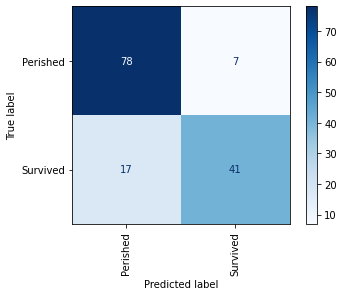

In [9]:
%matplotlib inline
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(model, x_test, y_test, display_labels=['Perished', 'Survived'], cmap='Blues', xticks_rotation='vertical')

Print a classification report to view precision, recall, and other metrics.

In [10]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.82      0.92      0.87        85
           1       0.85      0.71      0.77        58

    accuracy                           0.83       143
   macro avg       0.84      0.81      0.82       143
weighted avg       0.83      0.83      0.83       143



Finally, visualize the model's accuracy by plotting an ROC curve.

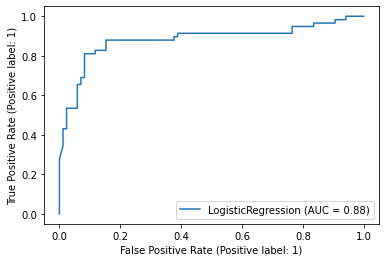

In [11]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(model, x_test, y_test)

## Use the model to make predictions

Now use the model to predict whether a 30-year-old female traveling in first class will survive the voyage.

In [12]:
female = [[30, 1, 0, 1, 0, 0]]
model.predict(female)[0]

1

More to the point, what is the probability that a 30-year-old female traveling in first class will survive?

In [13]:
probability = model.predict_proba(female)[0][1]
print(f'Probability of survival: {probability:.1%}')

Probability of survival: 91.6%


How about a 60-year-old male traveling in third class?

In [14]:
male = [[60, 0, 1, 0, 0, 1]]
probability = model.predict_proba(male)[0][1]
print(f'Probability of survival: {probability:.1%}')

Probability of survival: 2.9%
